# Cyberbullying Text Classification
CS6120 Group 10: Pushyanth Damarapati, Sindhya Balasubramanian, Eileen Chang, Priyanka Padinam

### Description
The rise of social media and the recent couple of years of covid-19 lockdown has led to a concerning increase in cyberbullying cases. In 2020, UNICEF even issued a warning in response to the increased cyberbullying compounded by social distancing and increased screen-time. Those who bully others on the internet have the convenience of being able to hide anonymously behind a screen, but the people who are bullied are likely to develop mental-health issues that persist even after the bullying has ceased. Due to social media’s ability to spread information quickly and anonymously, a single person can easily end up being targeted by a large number of people of various demographics. We aim to create a model that will flag harmful tweets and, therefore, protect targets of cyberbullying.

### Dataset
We will be using a kaggle dataset, Cyberbullying Classification, consisting of more than 47,000 tweets labeled according to 6 classes of cyberbullying: Age, Ethnicity, Gender, Religion, Other type of cyberbullying, and Not cyberbullying. Each row of the dataset will have a tweet and its class of cyberbullying. The dataset is meant to be used to create a multi-classification model to predict cyberbullying type, create a binary classification model to flag potentially harmful tweets, and examine words and patterns associated with each type of cyberbullying.

# Importing Dataset and Libraries

In [2]:
!pip install contractions
# !pip install nltk
!pip install autocorrect 
# !pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 11.7 MB/s 
     |████████████████████████████████| 110 kB 19.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 622 kB 5.6 MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622381 sha256=f9b5b05121f12a8baa81b1c061604074f924f55231a0390cea860125cd8b75a2
  Stored in directory: /root/.cache/pip/wheels/72/b8/3b/a90246d13090e85394a8a44b78c8abf577c0766f29d6543c75
Successfully built autocorrect


In [3]:
import string 
import nltk 
import re # regex
from string import punctuation 
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer 
from contractions import contractions_dict # to solve contractions
from autocorrect import Speller # correct spelling
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

#Libraries 
import matplotlib.pyplot as plt
import seaborn as sns


#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import RandomOverSampler

# #Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

import os

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
import numpy as np
import pandas as pd

df = pd.read_csv('cyberbullying_tweets.csv')
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

**There is not much imbalance between different cyberbulling type. other_cyberbulling will be removed since it may cause a confusion for the models with other cyberbullying class.**

In [5]:
df.drop(df[df['cyberbullying_type'] == 'other_cyberbullying'].index, inplace = True)
df['cyberbullying_type'].value_counts()

religion             7998
age                  7992
gender               7973
ethnicity            7961
not_cyberbullying    7945
Name: cyberbullying_type, dtype: int64

# 1. Data Preprocessing

In [6]:
# Renaming Categories
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [7]:
# Checking 10 samples
df.sample(10)

,text,sentiment
15912,.@MaddyBaylor @LBigmann Estimates are guesses ...,gender
47447,Racism is wen u select ur White clothes to was...,ethnicity
32928,"if we're really on the ""school shootings are o...",age
6530,RT @landofcoIfer: it's been one year since thi...,not_cyberbullying
3582,"Deconstructed lemon tart, brought to you by He...",not_cyberbullying
2557,@plrdirectory Another #plr provider discovery ...,not_cyberbullying
7357,RT @GCobber99: Bloody hell is there One libera...,not_cyberbullying
12508,RT @COVOEC1 not sexist but come on why ? ghost...,gender
4426,@Julia_Yates no we got kicked out so we came t...,not_cyberbullying
2169,"@TheNamesBreeyah , Me &amp; Jackie Song Togeth...",not_cyberbullying


In [8]:
df["target_bullying"] = np.where(df['sentiment']!="not_cyberbullying",1,0)
df

,text,sentiment,target_bullying
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0
...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,1
47688,Turner did not withhold his disappointment. Tu...,ethnicity,1
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,1
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,1


In [9]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
df["type_bullying"] = LE.fit_transform(df["sentiment"])
df

,text,sentiment,target_bullying,type_bullying
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0,3
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0,3
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0,3
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0,3
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0,3
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,1,1
47688,Turner did not withhold his disappointment. Tu...,ethnicity,1,1
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,1,1
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,1,1


In [10]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('omw-1.4')
sw_eng = stopwords.words('english')
def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 

    '''
    review_in_lowercase = review.lower()
    no_punctuation = review_in_lowercase.translate(review_in_lowercase.maketrans('', '', string.punctuation))
    no_url = re.sub(r'https?:\/\/.*[\r\n]*','', no_punctuation)
    review_tokens = word_tokenize(no_url)
    no_stopwords_tokens = [token for token in review_tokens if not token in sw_eng]
    porter = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    review_cleaned = ''
    
    for each in no_stopwords_tokens:
        review_cleaned = review_cleaned + lemmatizer.lemmatize(each) + " "
    
    return review_cleaned

df['text'] = df['text'].apply(lambda x : clean_review(x))

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [11]:
df['target_bullying'].value_counts()

1    31924
0     7945
Name: target_bullying, dtype: int64

# 2. Modeling

<b>Modeling to Predict Two-ClassText Classification as Cyber Bullying vs Not 
Cyber Bullying </b>

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


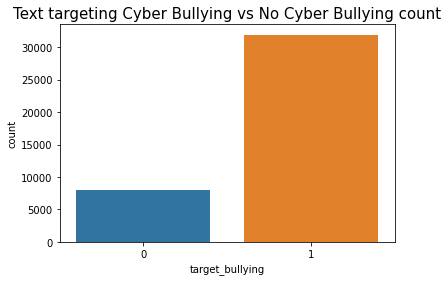

In [12]:
# Visualizing the data class imbalance

plt.figure(figsize = None)
sns.countplot(df.target_bullying)
plt.title("Text targeting Cyber Bullying vs No Cyber Bullying count", fontsize = 15)
plt.show()

To ensure there no class imbalance, post visualization, the data will over/under sampled based on the majority and minority classes noted in the data


In [13]:
# Sampling data to remove class imbalance

from sklearn.utils import resample

df_majority = df[df['target_bullying'] == 1];
df_minority = df[df['target_bullying'] == 0];

negative_upsample = resample(df_majority, replace = True, 
                        n_samples = df_minority.shape[0],
                        random_state = 40)

df_downsampled = pd.concat([df_minority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_downsampled = df_downsampled.sample(frac = 1)

In [14]:
df_downsampled.target_bullying.value_counts()

1    7945
0    7945
Name: target_bullying, dtype: int64

Post preprocessing and sampling, the documents will tokenized and converted to an appropriate vector format for model consumption using Bag of Words (countvectorizer)

In [15]:
# Count vectorizer on 
cv = CountVectorizer()

# fit and transform on dataset
X = cv.fit_transform(df_downsampled.text).toarray()

# Set target variable
y = df_downsampled.target_bullying

In [16]:
len(X)

15890

In [17]:
y.head()

15571    1
46924    1
39502    1
5029     0
861      0
Name: target_bullying, dtype: int64

Data will be divided into Training (60%), Validation(20%) and Test set (20%) using Scikit-learn’s train test data separator method using random seed

In [18]:
# Divide data into training, validation and test (60%, 20% and 20% respectively)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2);

In [19]:
print ("Training Data Shape ")
print(len(x_train))
print(len(y_train))
print ("Test Data Shape ")
print(len(x_test))
print(len(y_test))

Training Data Shape 
12712
12712
Test Data Shape 
3178
3178


Below is the CNN implementation with different regularization and
dropout layers

In [20]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Convolution1D
from keras.optimizers import SGD 
tf.random.set_seed(31)

In [24]:
X = np.expand_dims(x_train, axis=-1)

model = Sequential()

model.add(layers.Embedding(len(X), 50, input_length=29749))

model.add(Convolution1D(filters=32, kernel_size=1,strides = 3, input_shape=(256,1)))

model.add(layers.GlobalMaxPooling1D())    

model.add(layers.Dense(128, activation=activations.tanh, kernel_regularizer=l2()))

model.add(layers.Dense(64, activation=activations.relu))

model.add(layers.Dense(32, activation=activations.relu))

model.add(Dropout(0.5))

model.add(layers.Dense(units=1, activation='sigmoid'))

model.compile(loss= 'binary_crossentropy', optimizer='rmsprop', metrics=['AUC', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])

In [25]:
history = model.fit(x_train, y_train, verbose=False, batch_size = 16, epochs = 10, validation_split=0.25);

In [26]:
history.history['val_accuracy']

[0.5409062504768372,
 0.5745751857757568,
 0.5745751857757568,
 0.5745751857757568,
 0.5745751857757568,
 0.5745751857757568,
 0.5733165740966797,
 0.5745751857757568,
 0.5745751857757568,
 0.5745751857757568]

In [28]:
####################################
# PLOT :                           #
# train loss vs val loss           #
# train auc vs val auc             #
# train recall vs val recall       #
# train precision vs val precision #
# train accuracy vs val accuracy   #
####################################

print(history.history.keys())
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_auc = history.history['auc']
val_auc = history.history['val_auc']

train_recall = history.history['recall_1']
val_recall = history.history['val_recall_1']

train_prec = history.history['precision_1']
val_prec = history.history['val_precision_1']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

dict_keys(['loss', 'auc', 'precision_1', 'recall_1', 'accuracy', 'val_loss', 'val_auc', 'val_precision_1', 'val_recall_1', 'val_accuracy'])


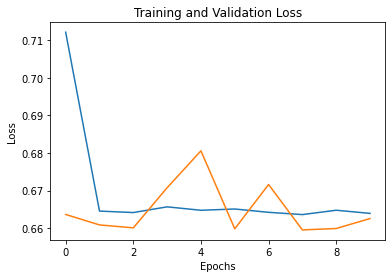

In [29]:
# Plot and label the training and validation loss values
plt.plot(list(range(0,10)), train_loss, label='Training Loss')
plt.plot(list(range(0,10)), val_loss, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the plot
plt.show()

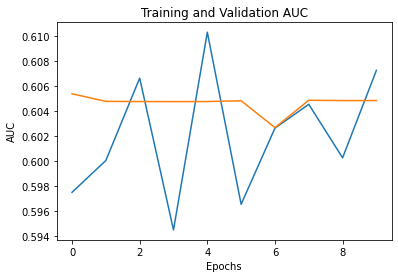

In [30]:
# Plot and label the training and validation AUC values
plt.plot(list(range(0,10)), train_auc, label='Training AUC')
plt.plot(list(range(0,10)), val_auc, label='Validation AUC')
 
# Add in a title and axes labels
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
 
# Display the plot
plt.show()

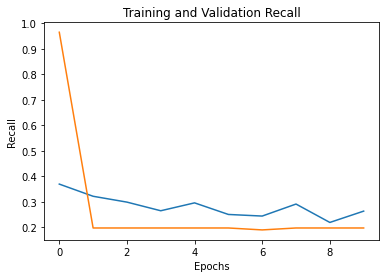

In [31]:
# Plot and label the training and validation recall values
plt.plot(list(range(0,10)), train_recall, label='Training Recall')
plt.plot(list(range(0,10)), val_recall, label='Validation Recall')
 
# Add in a title and axes labels
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')

# Display the plot
plt.show()

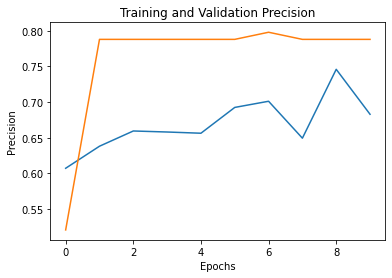

In [32]:
# Plot and label the training and validation precision values
plt.plot(list(range(0,10)), train_prec, label='Training Precision')
plt.plot(list(range(0,10)), val_prec, label='Validation Precision')
 
# Add in a title and axes labels
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')

# Display the plot
plt.show()

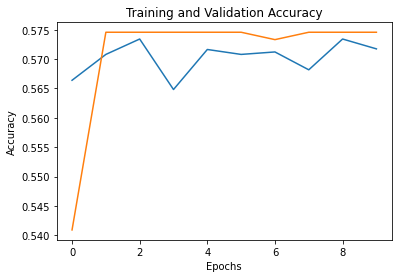

In [33]:
# Plot and label the training and validation accuracy values
plt.plot(list(range(0,10)), train_acc, label='Training Accuracy')
plt.plot(list(range(0,10)), val_acc, label='Validation Accuracy')
 
# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Display the plot
plt.show()